# Introduction

Goals:
* Determine if certain residue positions move more than others
* Determine if movement is plastic versus rigid body deformation

In [1]:
import os
import itertools
import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from python_pdb.aligners import align_pandas_structure, align_sequences
from python_pdb.parsers import parse_pdb
from python_pdb.comparisons import rmsd
from python_pdb.formats.residue import THREE_TO_ONE_CODE
from tcr_structure_tools.cdr_numbering import assign_cdr_number

In [2]:
DATA_DIR = '/project/koohylab/bmcmaste/projects/tcr-pmhc-interface-analysis/data/apo-holo-mhc-class-I-synthetic_refined_aligned'

# Measuring movement for each residue position

In [3]:
CHAIN_ANNOTATIONS = {
    'D': 'alpha_chain', 
    'E': 'beta_chain', 
    'C': 'antigen_chain', 
    'A': 'mhc_chain',
}

def get_coords(df):
    return df[['pos_x', 'pos_y', 'pos_z']].to_numpy()

def get_distance(vec1, vec2):
    xx = np.square(vec1[:, 0] - vec2[:, 0])
    yy = np.square(vec1[:, 1] - vec2[:, 1])
    zz = np.square(vec1[:, 2] - vec2[:, 2])
    
    return np.sqrt(xx + yy + zz)

In [4]:
CHI_ATOMS = pd.read_csv('chi-angles.csv', index_col='tlc')

def measure_chi_angle(residue_df: pd.DataFrame) -> float:
    res_name = residue_df.iloc[0]['residue_name']
    chi_atoms = CHI_ATOMS.loc[res_name][['atom_1', 'atom_2', 'atom_3', 'atom_4']].to_list()
    
    atom_positions = [residue_df.query("atom_name == @atom")[['pos_x', 'pos_y', 'pos_z']].iloc[0].to_numpy() for atom in chi_atoms]
    
    b1 = atom_positions[1] - atom_positions[0]
    b2 = atom_positions[2] - atom_positions[1]
    b3 = atom_positions[3] - atom_positions[1]
    
    b1_norm = b1 / np.linalg.norm(b1)
    b2_norm = b2 / np.linalg.norm(b2)
    b3_norm = b3 / np.linalg.norm(b3)
    
    n1 = np.cross(b1_norm, b2_norm)
    n2 = np.cross(b2_norm, b3_norm)
    
    m1 = np.cross(n1, b2_norm)
    
    x = np.dot(n1, n2)
    y = np.dot(m1, n2)
    
    return np.arctan2(x, y)

In [5]:
def align_tcrs(tcr_mobile_df, tcr_target_df):            
    mobile_coords = []
    target_coords = []
        
    for chain_type in ('alpha_chain', 'beta_chain'):
        fw_chain_sequences = []
        fw_chain_ca_coords = []
        
        for df in (tcr_mobile_df, tcr_target_df):
            fw_chain = df.query('cdr.isnull() and residue_seq_id < 128 and chain_type == @chain_type')
            
            fw_chain_ca_coords.append(fw_chain.query("atom_name == 'CA'")[['pos_x', 'pos_y', 'pos_z']].values)
            
            fw_chain_seq = fw_chain.drop_duplicates(['residue_seq_id', 'residue_insert_code'])['residue_name'].map(lambda tlc: THREE_TO_ONE_CODE[tlc]).tolist()
            fw_chain_sequences.append(fw_chain_seq)
        
        fw_chain_seq_alignment, _ = align_sequences(*fw_chain_sequences)
        

        iter_mobile_ca_coords = iter(fw_chain_ca_coords[0])
        iter_target_ca_coords = iter(fw_chain_ca_coords[1])

        for res_id_mobile, res_id_target in fw_chain_seq_alignment:
            next_res_ca_coords_mobile = next(iter_mobile_ca_coords) if res_id_mobile != '-' else None
            next_res_ca_coords_target = next(iter_target_ca_coords) if res_id_target != '-' else None

            if next_res_ca_coords_mobile is not None and next_res_ca_coords_target is not None:
                mobile_coords.append(next_res_ca_coords_mobile)
                target_coords.append(next_res_ca_coords_target)

    mobile_coords = np.array(mobile_coords)
    target_coords = np.array(target_coords)

    return align_pandas_structure(mobile_coords, target_coords, tcr_mobile_df)

In [6]:
groups = []
struct1s = []
struct2s = []
cdrs = []
chain_types = []
residue_names = []
residue_seq_ids = []
residue_insert_codes = []

# Measurements
ca_distances = []
rmsds = []
chi_angle_changes = []

for group in os.listdir(DATA_DIR):
    pdb_files = [file for file in os.listdir(os.path.join(DATA_DIR, group)) if file.endswith('.pdb')]
    
    for path1, path2 in itertools.combinations(pdb_files, 2):
        state1 = path1.split('.')[0].split('_')[2]
        state2 = path2.split('.')[0].split('_')[2]

        # Skip holo-holo and apo-apo comparisons for now
        if state1 == state2:
            continue
        
        if state1 == 'apo':
            apo_path = path1
            holo_path = path2
        else:
            apo_path = path2
            holo_path = path1
        

        # Load Structures
        with open(os.path.join(DATA_DIR, group, apo_path), 'r') as fh:
            apo_df = parse_pdb(fh.read(), silent=True).to_pandas()
        
        with open(os.path.join(DATA_DIR, group, holo_path), 'r') as fh:
            holo_df = parse_pdb(fh.read(), silent=True).to_pandas()

        # Annotate records
        apo_df['chain_type'] = apo_df['chain_id'].map(lambda chain_id: CHAIN_ANNOTATIONS[chain_id])
        holo_df['chain_type'] = holo_df['chain_id'].map(lambda chain_id: CHAIN_ANNOTATIONS[chain_id])
        
        apo_df['cdr'] = apo_df['residue_seq_id'].map(assign_cdr_number)
        holo_df['cdr'] = holo_df['residue_seq_id'].map(assign_cdr_number)
        
        apo_tcr_df = apo_df.query("chain_type == 'alpha_chain' or chain_type == 'beta_chain'")
        holo_tcr_df = holo_df.query("chain_type == 'alpha_chain' or chain_type == 'beta_chain'")
        
        apo_tcr_df = align_tcrs(apo_tcr_df, holo_tcr_df)     
        
        # Query desired residues/atoms
        for chain_type, cdr_number in itertools.product(['alpha_chain', 'beta_chain'], [1, 2, 3]):
            apo_cdr = apo_tcr_df.query("cdr == @cdr_number and chain_type == @chain_type")
            holo_cdr = holo_tcr_df.query("cdr == @cdr_number and chain_type == @chain_type")
            
            # Compute CA distance
            distance = get_distance(get_coords(apo_cdr.query("atom_name == 'CA'")),
                                    get_coords(holo_cdr.query("atom_name == 'CA'")))
            
            cdr_rmsds = []
            cdr_angle_changes = []
            
            cdr_residue_names = []
            cdr_seq_ids = []
            cdr_insert_codes = []
            
            group1 = apo_cdr.groupby(['residue_name', 'residue_seq_id', 'residue_insert_code'], dropna=False)
            group2 = holo_cdr.groupby(['residue_name', 'residue_seq_id', 'residue_insert_code'], dropna=False)
            
            for ((res_name, seq_id, insert_code), res1), (_, res2) in zip(group1, group2):
                # Compute RMSD for between every residue
                try:
                    cdr_rmsds.append(rmsd(get_coords(res1), get_coords(res2)))
                except ValueError:
                    print('Mismatched number of atoms in residue:')
                    print(path1, path2, res_name, seq_id, insert_code)
                    continue
                
                # Compute chi angle changes
                if res_name == 'GLY' or res_name == 'ALA':
                    cdr_angle_changes.append(None)
                else:
                    try:
                        cdr_angle_changes.append(measure_chi_angle(res1) - measure_chi_angle(res2))
                    except IndexError:
                        print('Missing atoms needed to calculate chi angle:')
                        print(path1, path2, res_name, seq_id, insert_code)
                        cdr_angle_changes.append(None)

                
                cdr_residue_names.append(res_name)
                cdr_seq_ids.append(seq_id)
                cdr_insert_codes.append(insert_code)
                
            # append values to lists
            num_residues = len(cdr_rmsds)
            
            residue_names += cdr_residue_names
            residue_seq_ids += cdr_seq_ids
            residue_insert_codes += cdr_insert_codes
            
            ca_distances += list(distance)
            rmsds += cdr_rmsds
            chi_angle_changes += cdr_angle_changes
            
            groups += [group] * num_residues
            struct1s += [path1] * num_residues
            struct2s += [path2] * num_residues
            
            cdrs += [cdr_number] * num_residues
            chain_types += [chain_type] * num_residues

results = pd.DataFrame({
    'group': groups,
    'struct1': struct1s,
    'struct2': struct2s,
    'cdr': cdrs,
    'chain_type': chain_types,
    'residue_name': residue_names,
    'residue_seq_id': residue_seq_ids,
    'residue_insert_code': residue_insert_codes,
    'ca_distance': ca_distances,
    'rmsd': rmsds,
    'chi_angle_change': chi_angle_changes,
})
results

,group,struct1,struct2,cdr,chain_type,residue_name,residue_seq_id,residue_insert_code,ca_distance,rmsd,chi_angle_change
0,AFNCTYSNSASQSFFWYRQD-EPKLLMSVYSSGNEDGRFTAQL-AT...,6vrm_DEPA_holo_ranked_2.pdb,6vth_DE_apo_ranked_2.pdb,1,alpha_chain,ALA,29,NaN,0.752743,0.853618,NaN
1,AFNCTYSNSASQSFFWYRQD-EPKLLMSVYSSGNEDGRFTAQL-AT...,6vrm_DEPA_holo_ranked_2.pdb,6vth_DE_apo_ranked_2.pdb,1,alpha_chain,ASN,27,NaN,0.870851,0.784333,-0.026934
2,AFNCTYSNSASQSFFWYRQD-EPKLLMSVYSSGNEDGRFTAQL-AT...,6vrm_DEPA_holo_ranked_2.pdb,6vth_DE_apo_ranked_2.pdb,1,alpha_chain,GLN,37,NaN,0.861466,1.015434,-0.018439
3,AFNCTYSNSASQSFFWYRQD-EPKLLMSVYSSGNEDGRFTAQL-AT...,6vrm_DEPA_holo_ranked_2.pdb,6vth_DE_apo_ranked_2.pdb,1,alpha_chain,SER,28,NaN,0.789116,0.887144,-0.017818
4,AFNCTYSNSASQSFFWYRQD-EPKLLMSVYSSGNEDGRFTAQL-AT...,6vrm_DEPA_holo_ranked_2.pdb,6vth_DE_apo_ranked_2.pdb,1,alpha_chain,SER,36,NaN,0.826201,0.802341,-0.029661
...,...,...,...,...,...,...,...,...,...,...,...
69095,NLPCNHSTISGNEYVYWYRQI-GPQYIIHGLKNNETNEMASLII-A...,3dx9_AB_apo_ranked_0.pdb,3dxa_DECA_holo_ranked_3.pdb,3,beta_chain,PHE,117,NaN,2.417289,0.369681,-0.000639
69096,NLPCNHSTISGNEYVYWYRQI-GPQYIIHGLKNNETNEMASLII-A...,3dx9_AB_apo_ranked_0.pdb,3dxa_DECA_holo_ranked_3.pdb,3,beta_chain,SER,106,NaN,2.224259,0.462888,0.027579
69097,NLPCNHSTISGNEYVYWYRQI-GPQYIIHGLKNNETNEMASLII-A...,3dx9_AB_apo_ranked_0.pdb,3dxa_DECA_holo_ranked_3.pdb,3,beta_chain,SER,112,NaN,0.646805,2.258009,0.152695
69098,NLPCNHSTISGNEYVYWYRQI-GPQYIIHGLKNNETNEMASLII-A...,3dx9_AB_apo_ranked_0.pdb,3dxa_DECA_holo_ranked_3.pdb,3,beta_chain,TYR,108,NaN,0.370912,1.427505,0.066538


In [8]:
results['resi'] = results['residue_seq_id'].apply(str) + results['residue_insert_code'].fillna('')

results['struct_1_form'] = results['struct1'].map(lambda path: path.split('.')[0].split('_')[2])
results['struct_2_form'] = results['struct2'].map(lambda path: path.split('.')[0].split('_')[2])

results['struct_1_model_rank'] = results['struct1'].map(lambda path: int(path.split('.')[0].split('_')[-1]))
results['struct_2_model_rank'] = results['struct2'].map(lambda path: int(path.split('.')[0].split('_')[-1]))

results

,group,struct1,struct2,cdr,chain_type,residue_name,residue_seq_id,residue_insert_code,ca_distance,rmsd,chi_angle_change,resi,struct_1_form,struct_2_form,struct_1_model_rank,struct_2_model_rank
0,AFNCTYSNSASQSFFWYRQD-EPKLLMSVYSSGNEDGRFTAQL-AT...,6vrm_DEPA_holo_ranked_2.pdb,6vth_DE_apo_ranked_2.pdb,1,alpha_chain,ALA,29,NaN,0.752743,0.853618,NaN,29,holo,apo,2,2
1,AFNCTYSNSASQSFFWYRQD-EPKLLMSVYSSGNEDGRFTAQL-AT...,6vrm_DEPA_holo_ranked_2.pdb,6vth_DE_apo_ranked_2.pdb,1,alpha_chain,ASN,27,NaN,0.870851,0.784333,-0.026934,27,holo,apo,2,2
2,AFNCTYSNSASQSFFWYRQD-EPKLLMSVYSSGNEDGRFTAQL-AT...,6vrm_DEPA_holo_ranked_2.pdb,6vth_DE_apo_ranked_2.pdb,1,alpha_chain,GLN,37,NaN,0.861466,1.015434,-0.018439,37,holo,apo,2,2
3,AFNCTYSNSASQSFFWYRQD-EPKLLMSVYSSGNEDGRFTAQL-AT...,6vrm_DEPA_holo_ranked_2.pdb,6vth_DE_apo_ranked_2.pdb,1,alpha_chain,SER,28,NaN,0.789116,0.887144,-0.017818,28,holo,apo,2,2
4,AFNCTYSNSASQSFFWYRQD-EPKLLMSVYSSGNEDGRFTAQL-AT...,6vrm_DEPA_holo_ranked_2.pdb,6vth_DE_apo_ranked_2.pdb,1,alpha_chain,SER,36,NaN,0.826201,0.802341,-0.029661,36,holo,apo,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69095,NLPCNHSTISGNEYVYWYRQI-GPQYIIHGLKNNETNEMASLII-A...,3dx9_AB_apo_ranked_0.pdb,3dxa_DECA_holo_ranked_3.pdb,3,beta_chain,PHE,117,NaN,2.417289,0.369681,-0.000639,117,apo,holo,0,3
69096,NLPCNHSTISGNEYVYWYRQI-GPQYIIHGLKNNETNEMASLII-A...,3dx9_AB_apo_ranked_0.pdb,3dxa_DECA_holo_ranked_3.pdb,3,beta_chain,SER,106,NaN,2.224259,0.462888,0.027579,106,apo,holo,0,3
69097,NLPCNHSTISGNEYVYWYRQI-GPQYIIHGLKNNETNEMASLII-A...,3dx9_AB_apo_ranked_0.pdb,3dxa_DECA_holo_ranked_3.pdb,3,beta_chain,SER,112,NaN,0.646805,2.258009,0.152695,112,apo,holo,0,3
69098,NLPCNHSTISGNEYVYWYRQI-GPQYIIHGLKNNETNEMASLII-A...,3dx9_AB_apo_ranked_0.pdb,3dxa_DECA_holo_ranked_3.pdb,3,beta_chain,TYR,108,NaN,0.370912,1.427505,0.066538,108,apo,holo,0,3


In [12]:
results_norm = results.groupby(['group',
                                'cdr',
                                'chain_type',
                                'residue_name',
                                'residue_seq_id', 'residue_insert_code', 'resi',
                                'struct_1_form', 'struct_2_form',
                                'struct_1_model_rank', 'struct_2_model_rank'],
                               dropna=False)[['ca_distance', 'rmsd', 'chi_angle_change']].mean().reset_index()

In [13]:
results_norm['chi_angle_change_mag'] = results_norm['chi_angle_change'].apply(np.abs)
results_norm['chi_angle_change_deg_mag'] = results_norm['chi_angle_change_mag'].apply(np.degrees)

In [14]:
apo_holo = results_norm.query("(struct_1_form != struct_2_form) and (struct_1_model_rank == struct_2_model_rank)").copy()
apo_holo['model_rank'] = apo_holo['struct_1_model_rank']
apo_holo

,group,cdr,chain_type,residue_name,residue_seq_id,residue_insert_code,resi,struct_1_form,struct_2_form,struct_1_model_rank,struct_2_model_rank,ca_distance,rmsd,chi_angle_change,chi_angle_change_mag,chi_angle_change_deg_mag,model_rank
7,AFNCTYSNSASQSFFWYRQD-EPKLLMSVYSSGNEDGRFTAQL-AT...,1,alpha_chain,ALA,29,NaN,29,apo,holo,4,4,1.065694,1.118834,NaN,NaN,NaN,4
8,AFNCTYSNSASQSFFWYRQD-EPKLLMSVYSSGNEDGRFTAQL-AT...,1,alpha_chain,ALA,29,NaN,29,holo,apo,0,0,0.550852,0.448503,NaN,NaN,NaN,0
13,AFNCTYSNSASQSFFWYRQD-EPKLLMSVYSSGNEDGRFTAQL-AT...,1,alpha_chain,ALA,29,NaN,29,holo,apo,1,1,1.062310,1.058055,NaN,NaN,NaN,1
17,AFNCTYSNSASQSFFWYRQD-EPKLLMSVYSSGNEDGRFTAQL-AT...,1,alpha_chain,ALA,29,NaN,29,holo,apo,2,2,0.752743,0.853618,NaN,NaN,NaN,2
23,AFNCTYSNSASQSFFWYRQD-EPKLLMSVYSSGNEDGRFTAQL-AT...,1,alpha_chain,ALA,29,NaN,29,holo,apo,3,3,0.533315,0.628284,NaN,NaN,NaN,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25542,VLNCSFTDSAIYNLQWFRQD-GLTSLLLIQSSQREQTSGRLNASL-...,3,beta_chain,VAL,109,NaN,109,apo,holo,4,4,0.054705,0.249111,0.066279,0.066279,3.797502,4
25543,VLNCSFTDSAIYNLQWFRQD-GLTSLLLIQSSQREQTSGRLNASL-...,3,beta_chain,VAL,109,NaN,109,holo,apo,0,0,0.084819,0.636321,-0.000963,0.000963,0.055159,0
25549,VLNCSFTDSAIYNLQWFRQD-GLTSLLLIQSSQREQTSGRLNASL-...,3,beta_chain,VAL,109,NaN,109,holo,apo,1,1,0.122876,0.697716,0.014406,0.014406,0.825421,1
25553,VLNCSFTDSAIYNLQWFRQD-GLTSLLLIQSSQREQTSGRLNASL-...,3,beta_chain,VAL,109,NaN,109,holo,apo,2,2,0.096027,0.154132,0.083535,0.083535,4.786212,2


# Visualising Results

## Ca movement

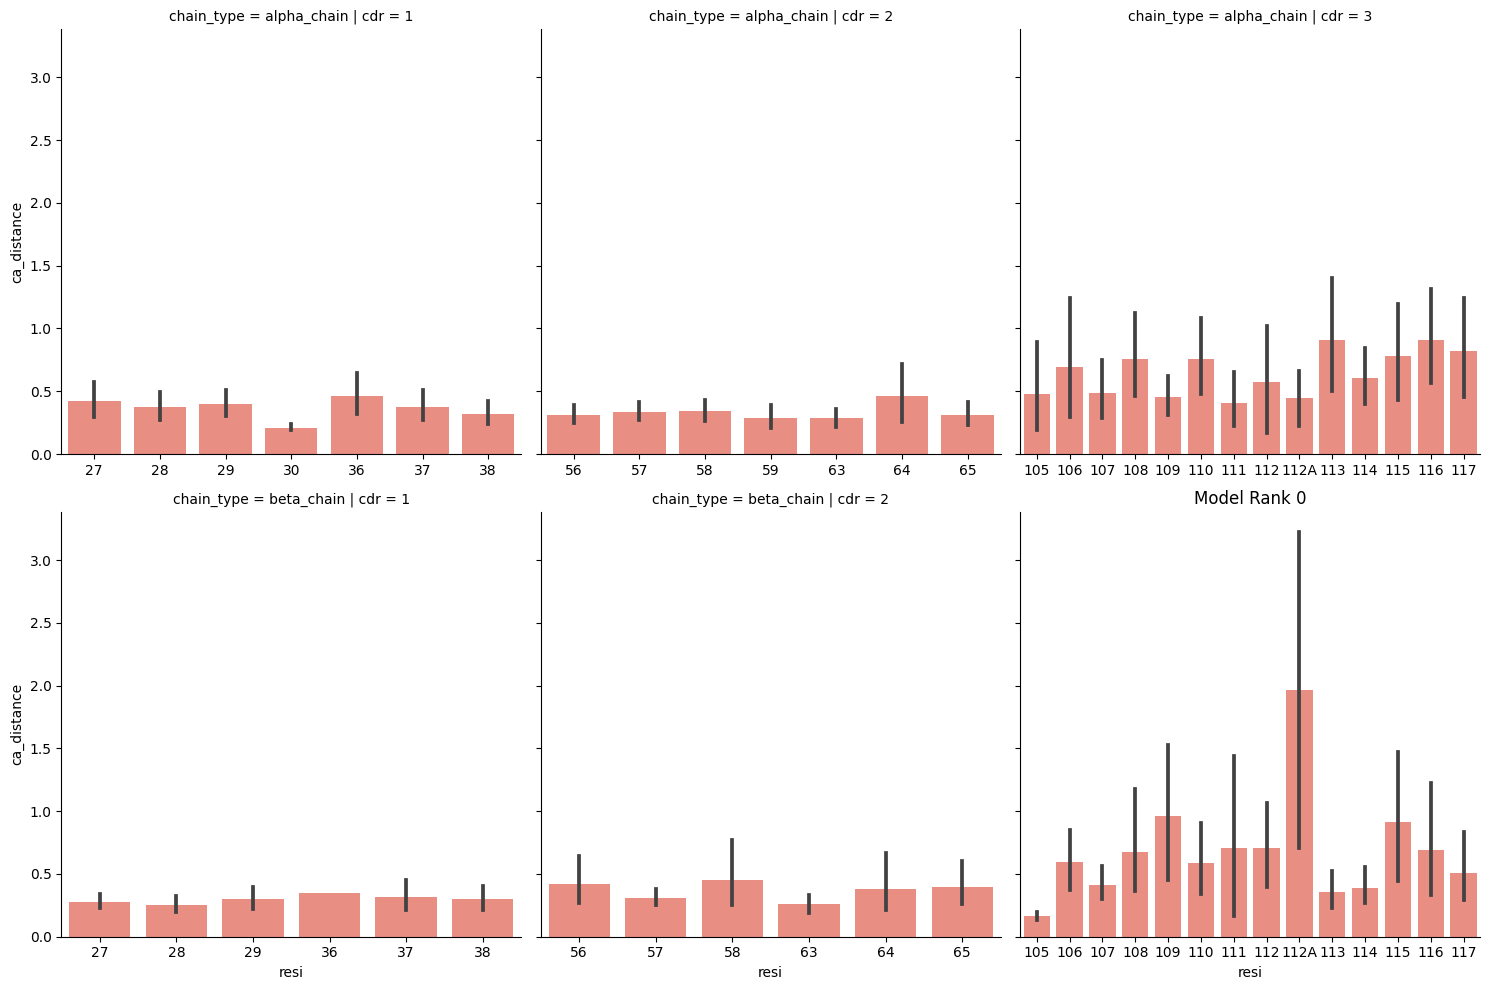

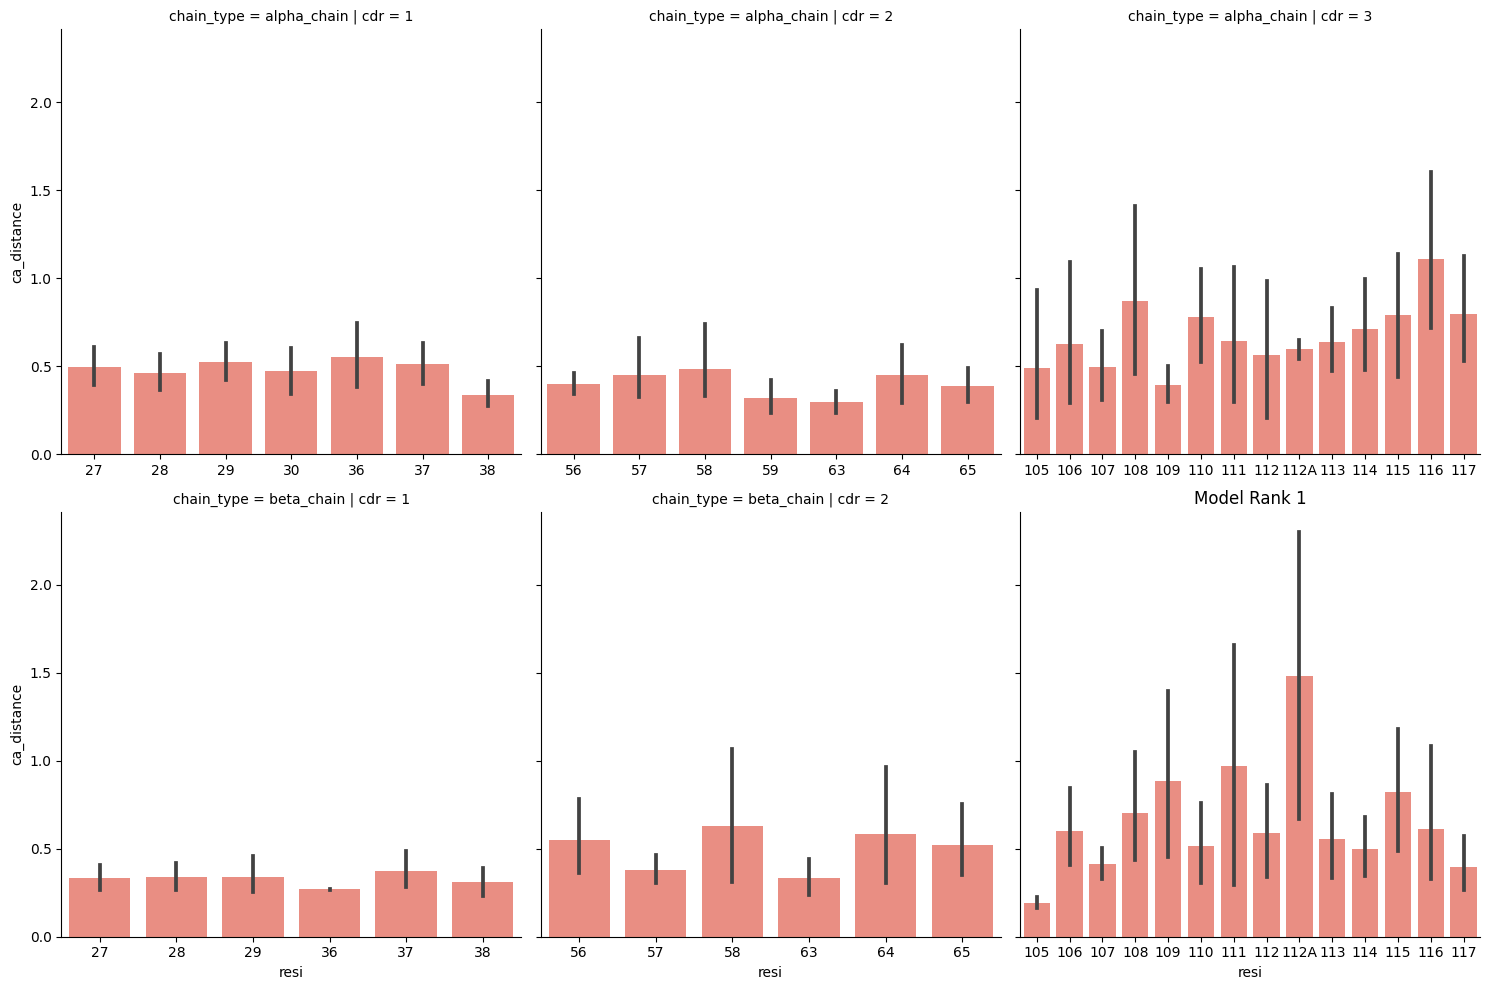

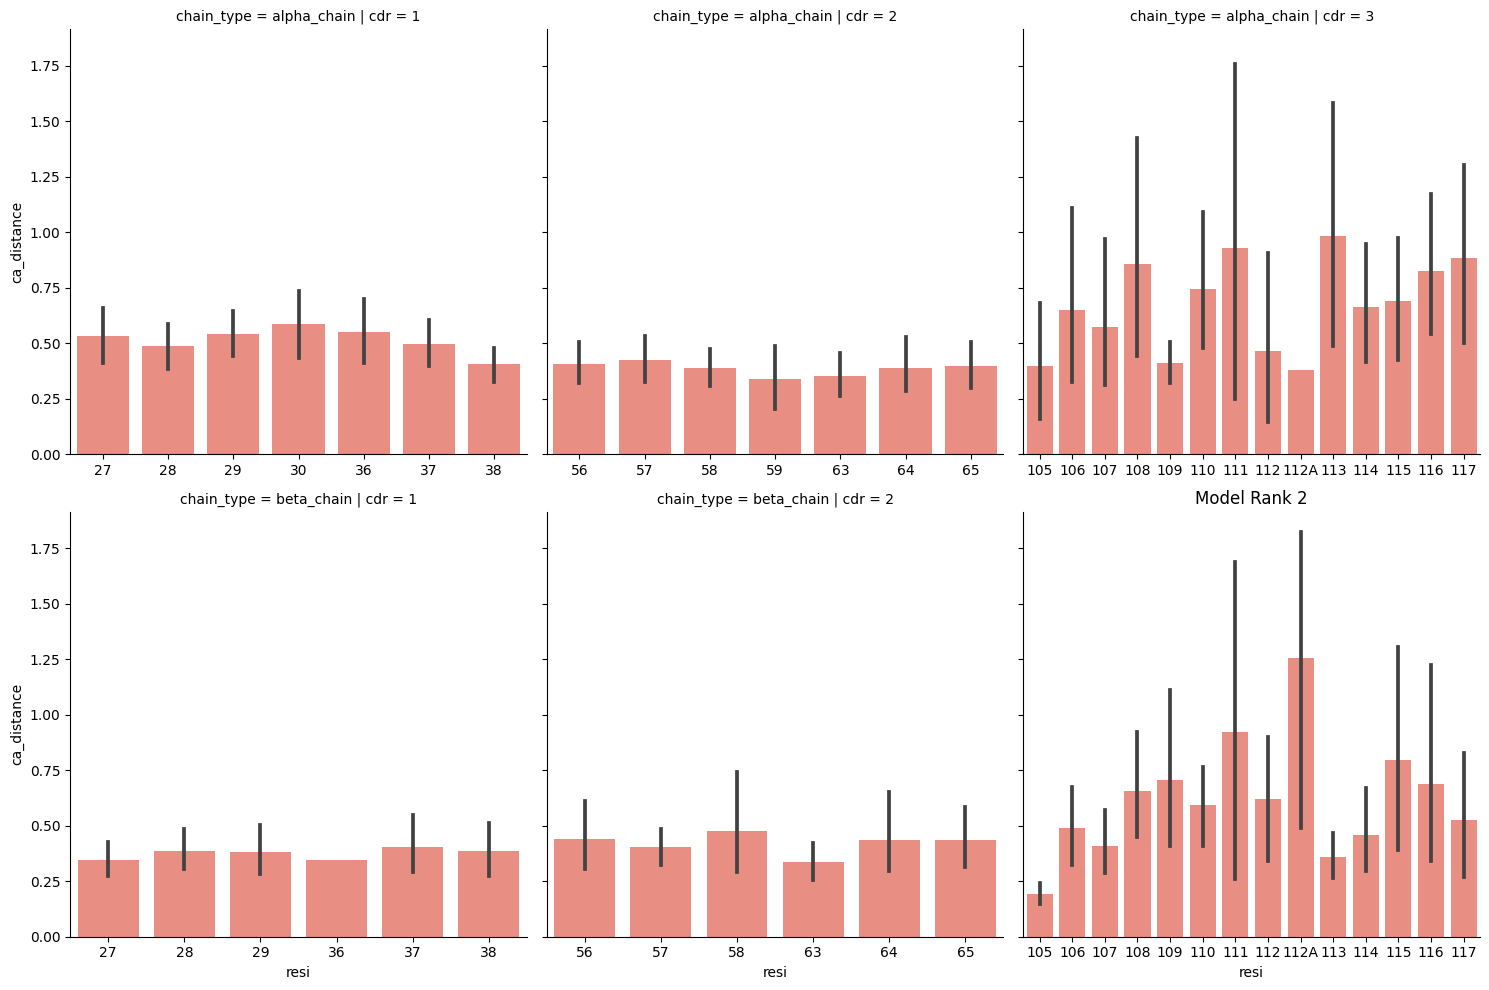

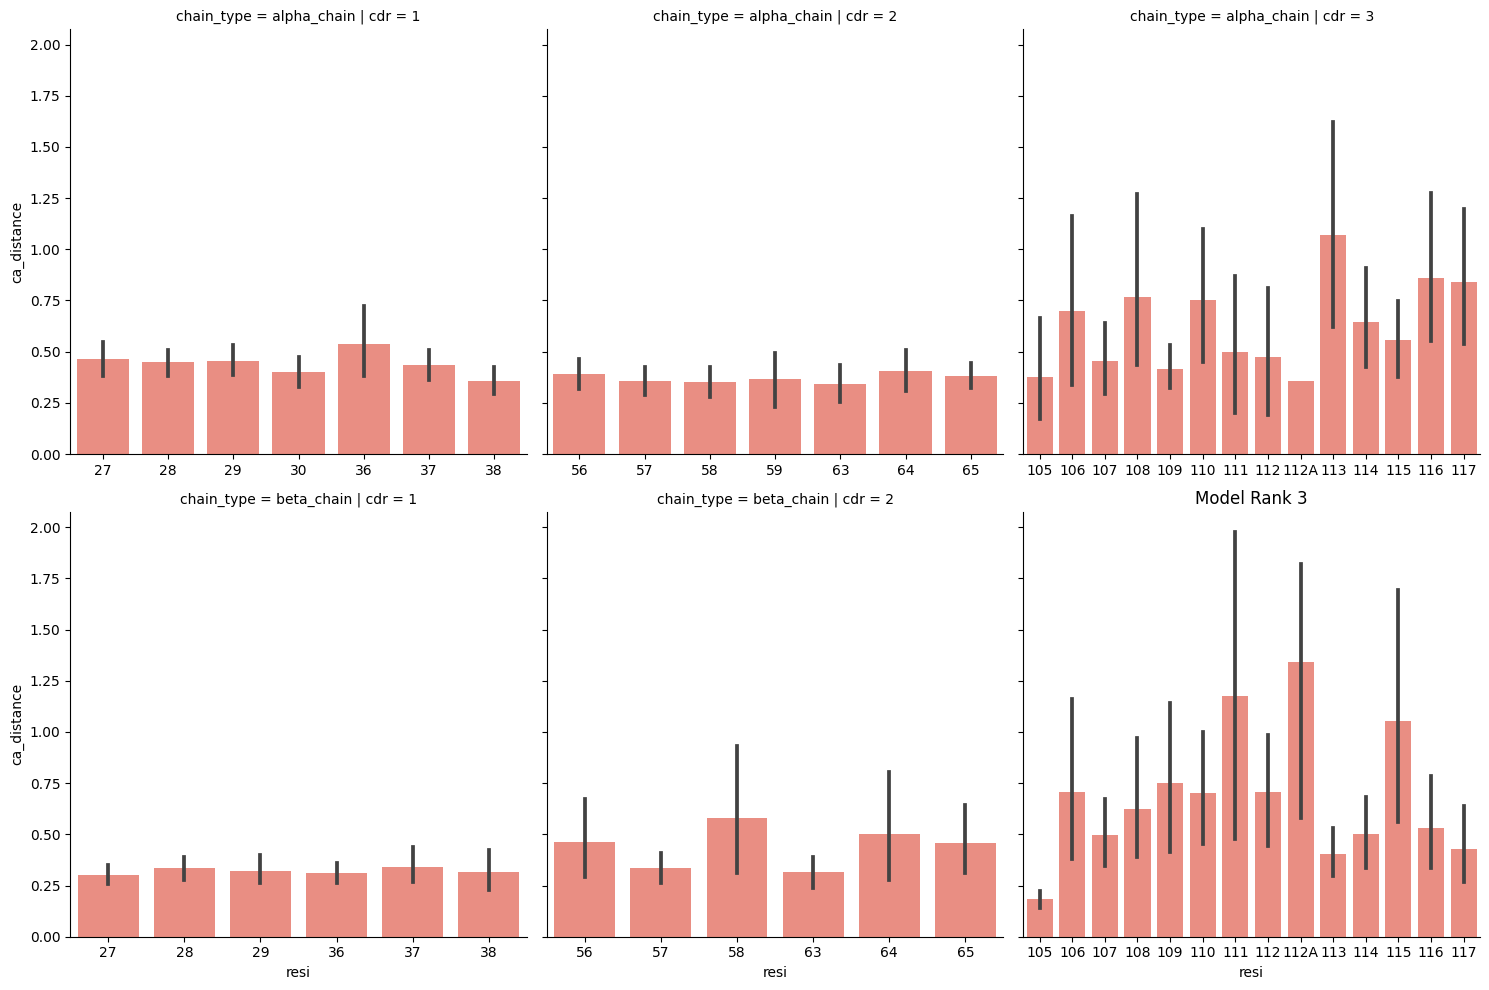

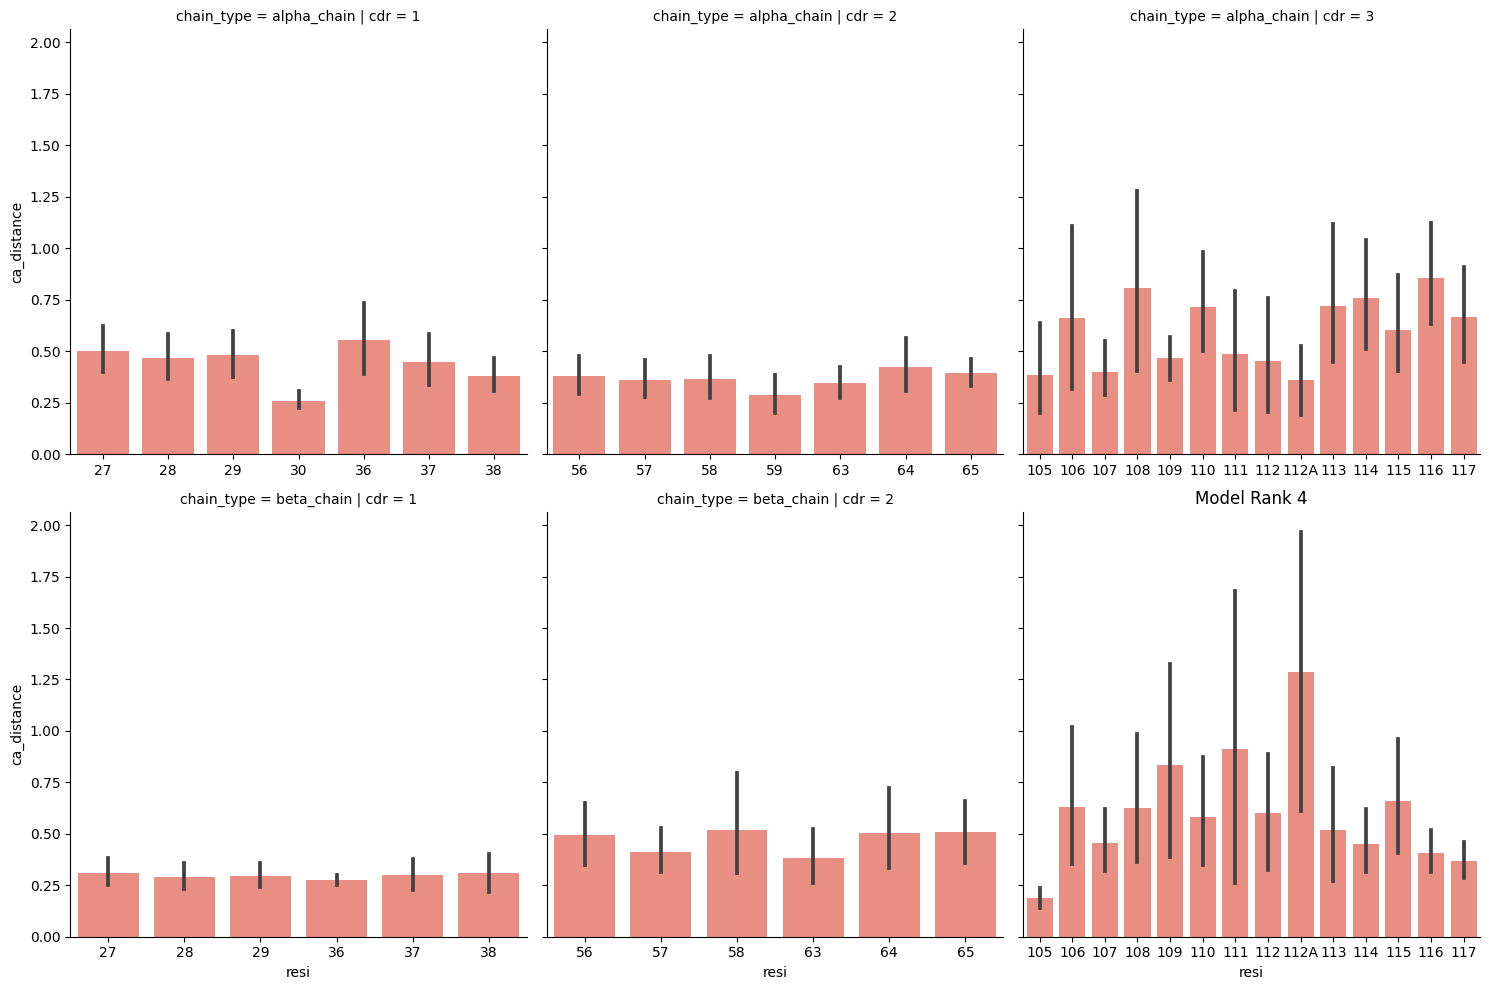

In [15]:
for model_rank in range(5):
    sns.catplot(apo_holo.query('model_rank == @model_rank').sort_values('resi'),
                x='resi', y='ca_distance',
                row='chain_type', col='cdr',
                color='salmon',
                sharex=False,
                kind='bar')
    plt.title(f'Model Rank {model_rank}')

## Residue RMSD difference

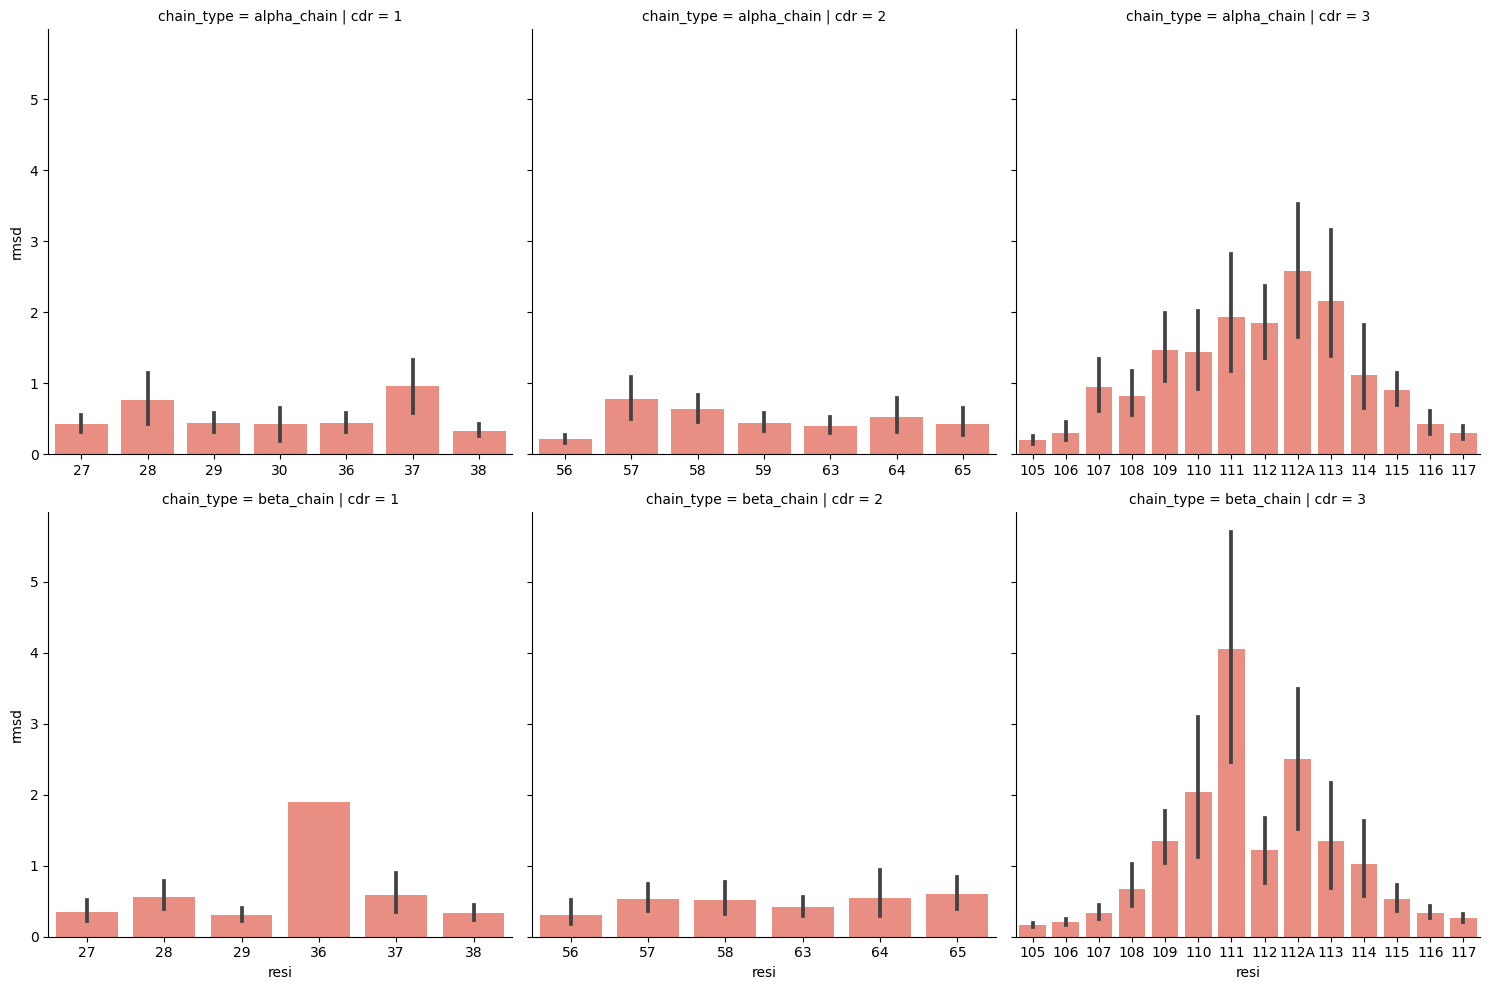

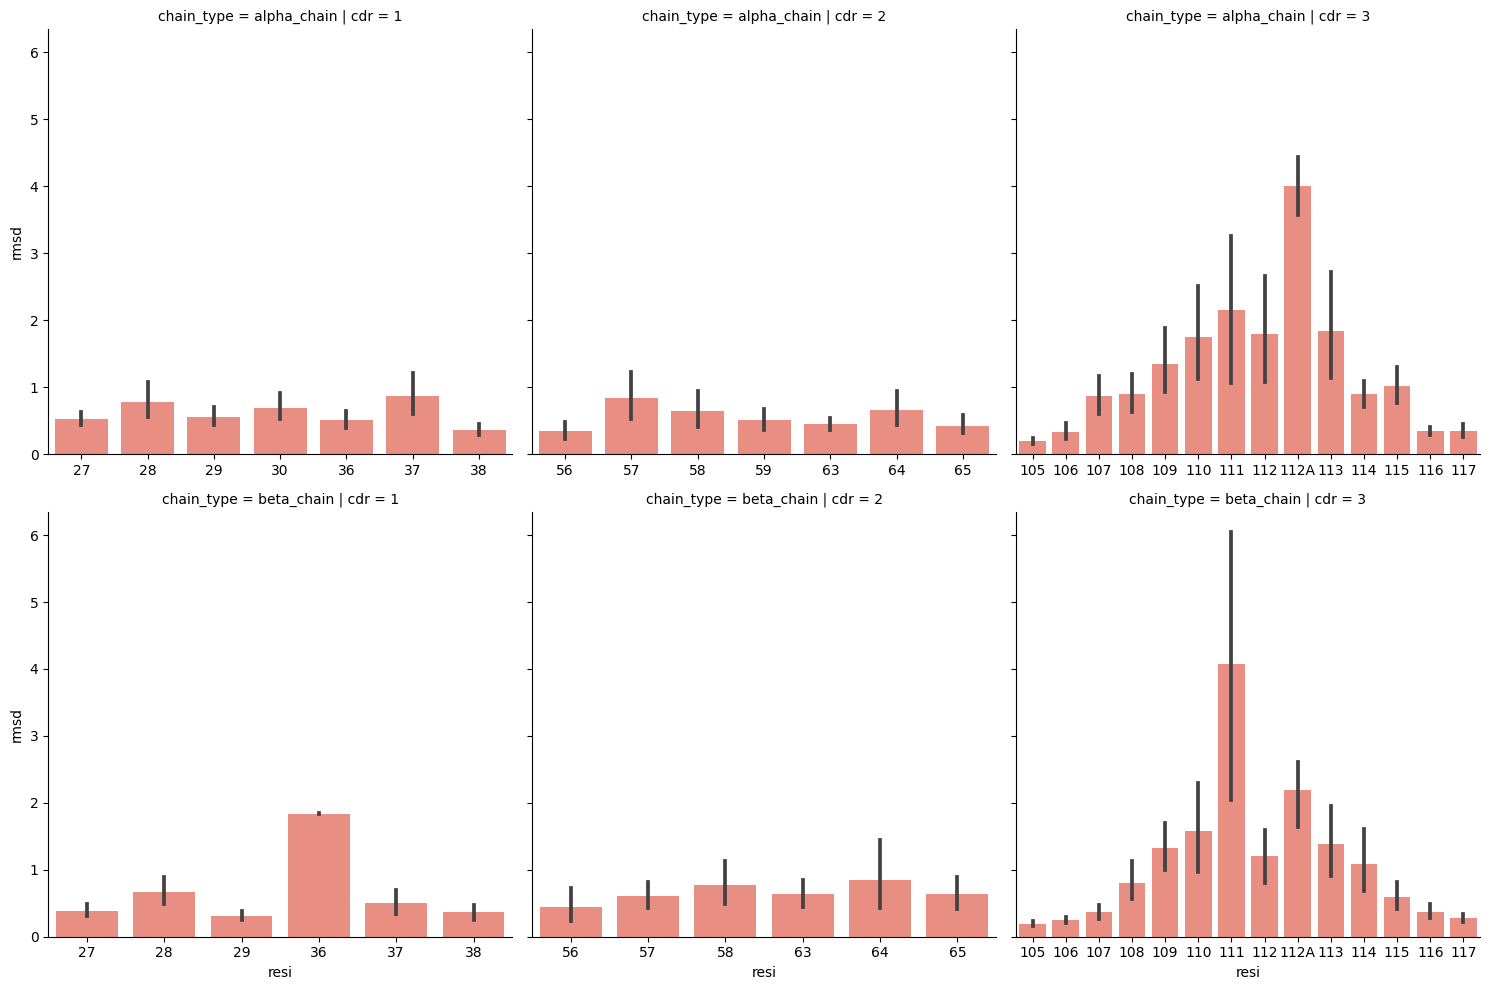

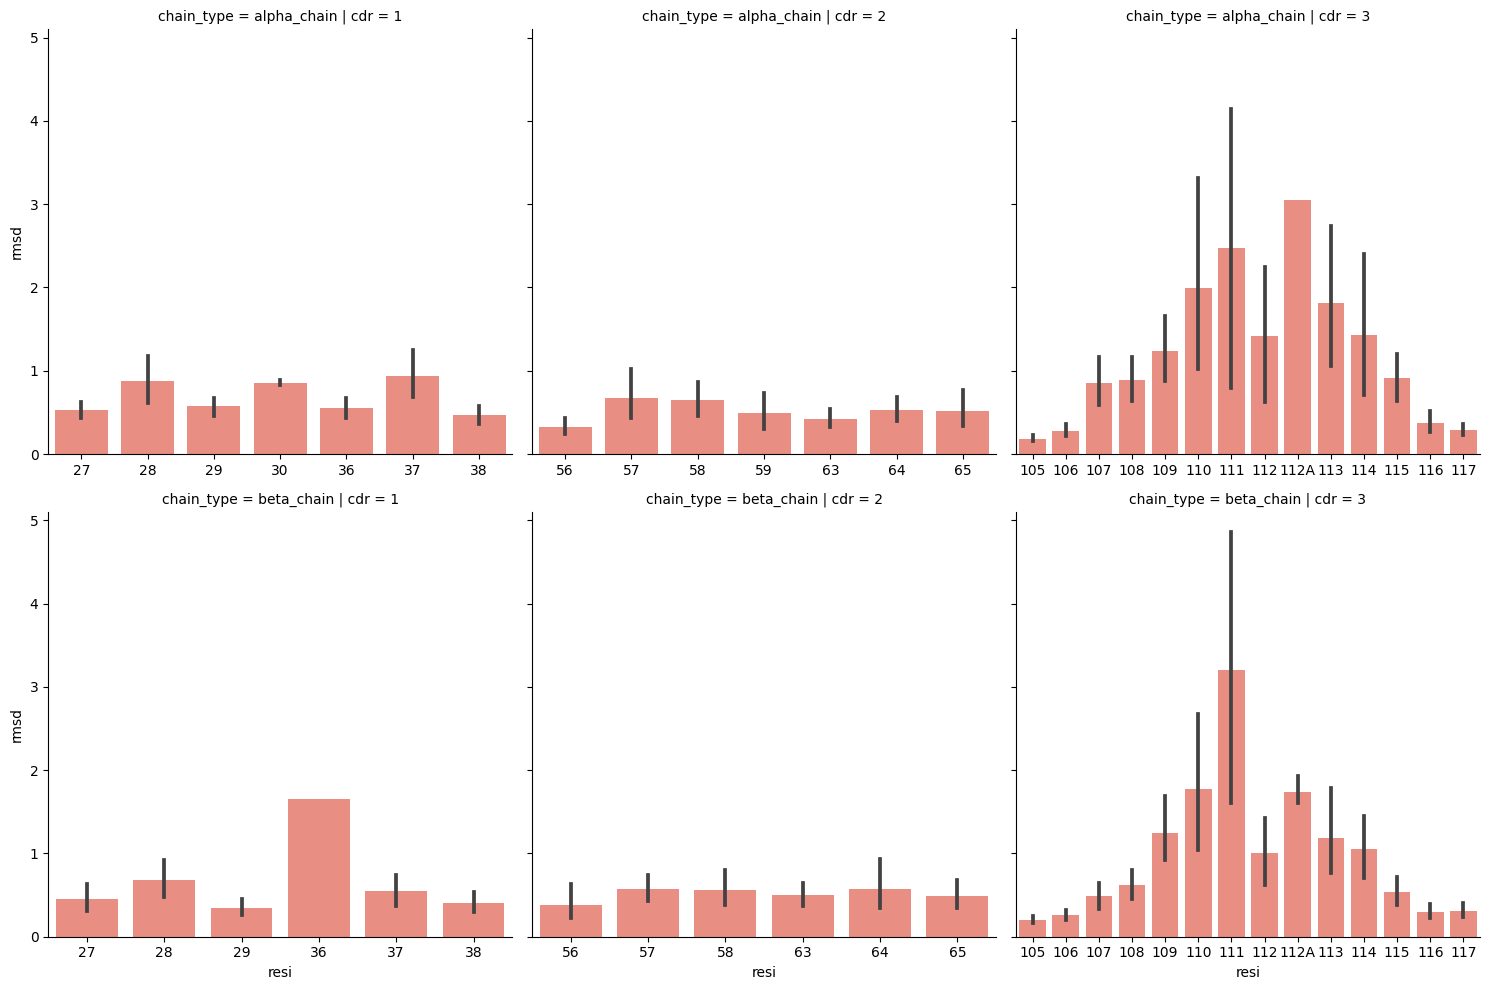

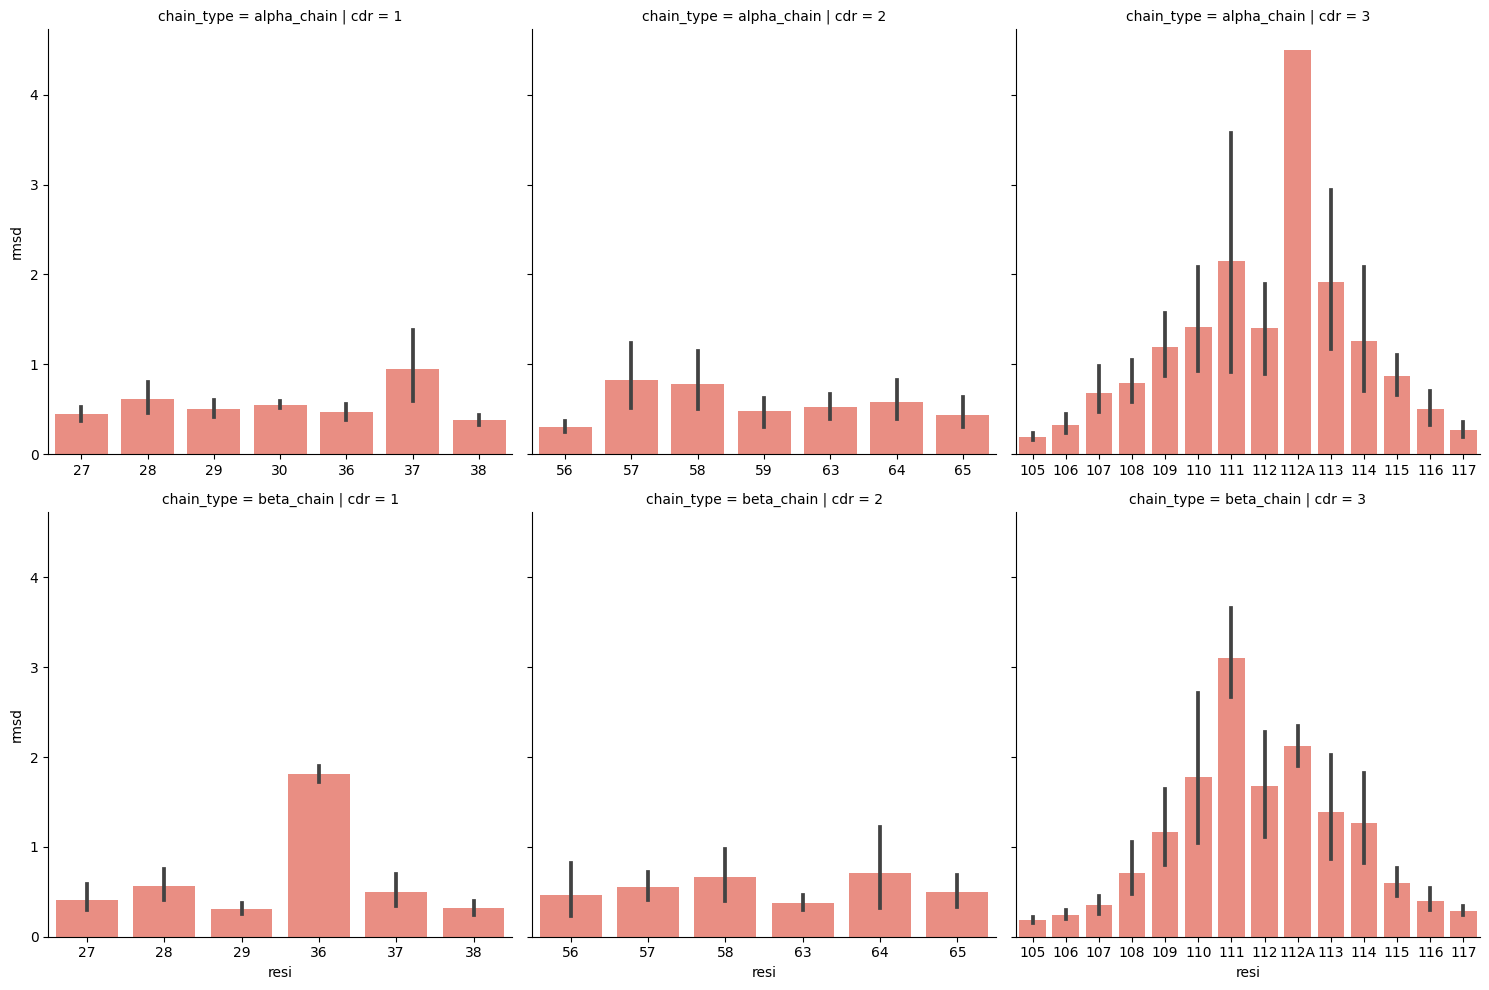

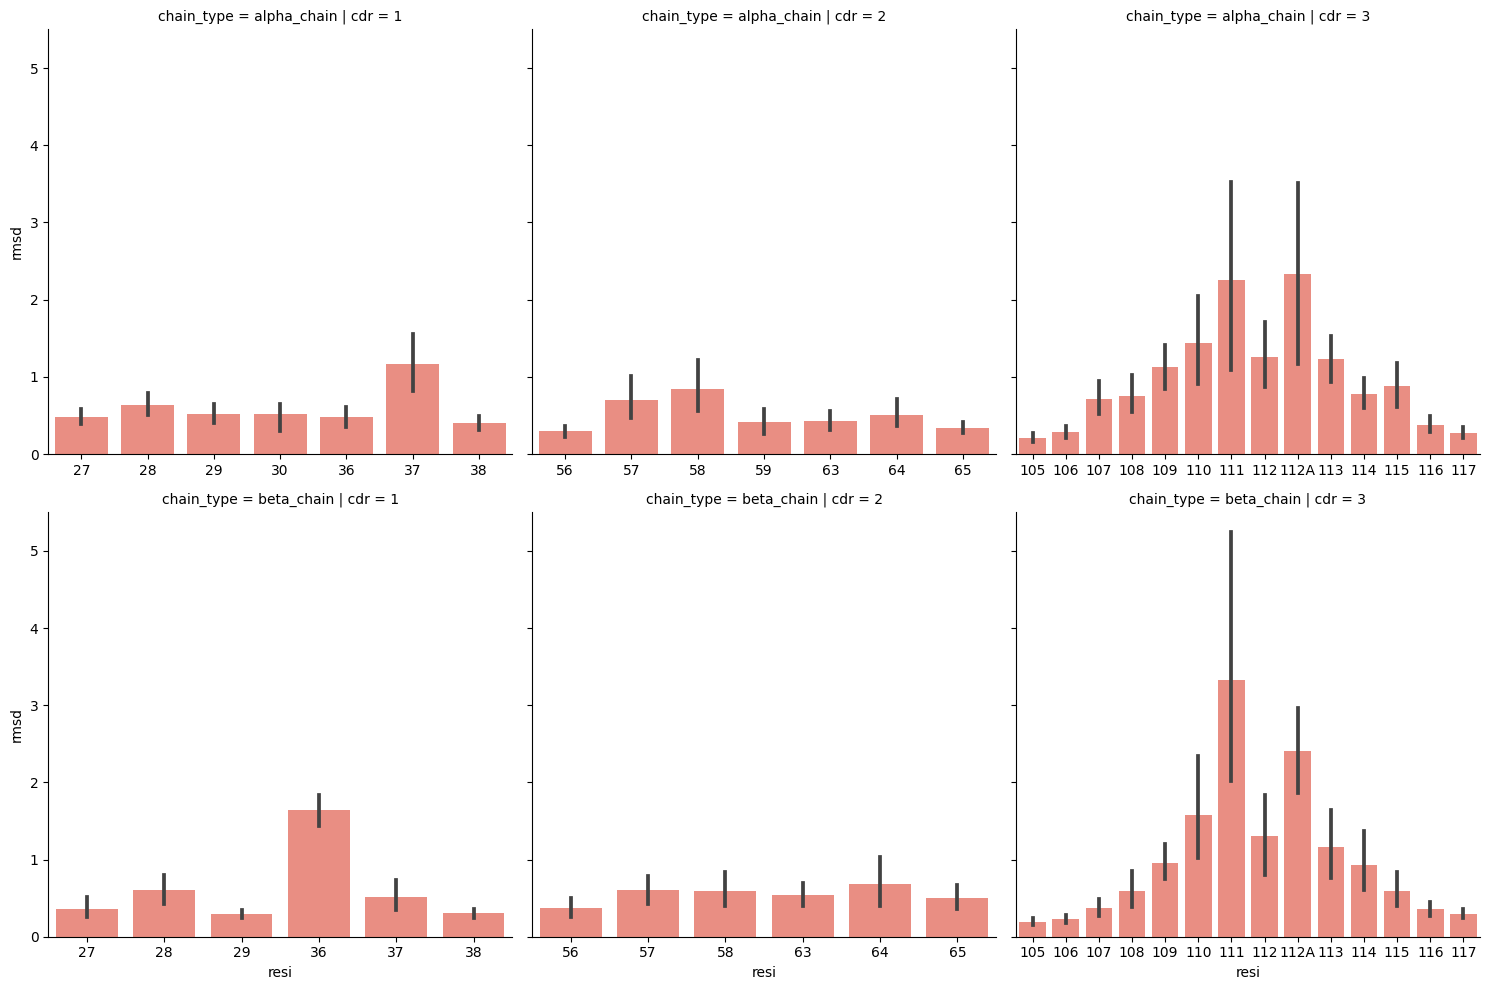

In [17]:
for model_rank in range(5):
    sns.catplot(apo_holo.query('model_rank == @model_rank').sort_values('resi'),
                x='resi', y='rmsd',
                row='chain_type', col='cdr',
                color='salmon',
                sharex=False,
                kind='bar')
    
#     if model_rank == 0:
#         plt.savefig('figures/per-res-rmsd-tcrmodel2.svg')

# Meseasuring differences in $\chi$-angles

Do the side chains change conformation as well?

/package/python-cbrg/current/3.11/lib/python3.11/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/package/python-cbrg/current/3.11/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/package/python-cbrg/current/3.11/lib/python3.11/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/package/python-cbrg/current/3.11/lib/python3.11/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/package/python-cbrg/current/3.11/lib/python3.11/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/package/python-cbrg/current/3.11/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  retur

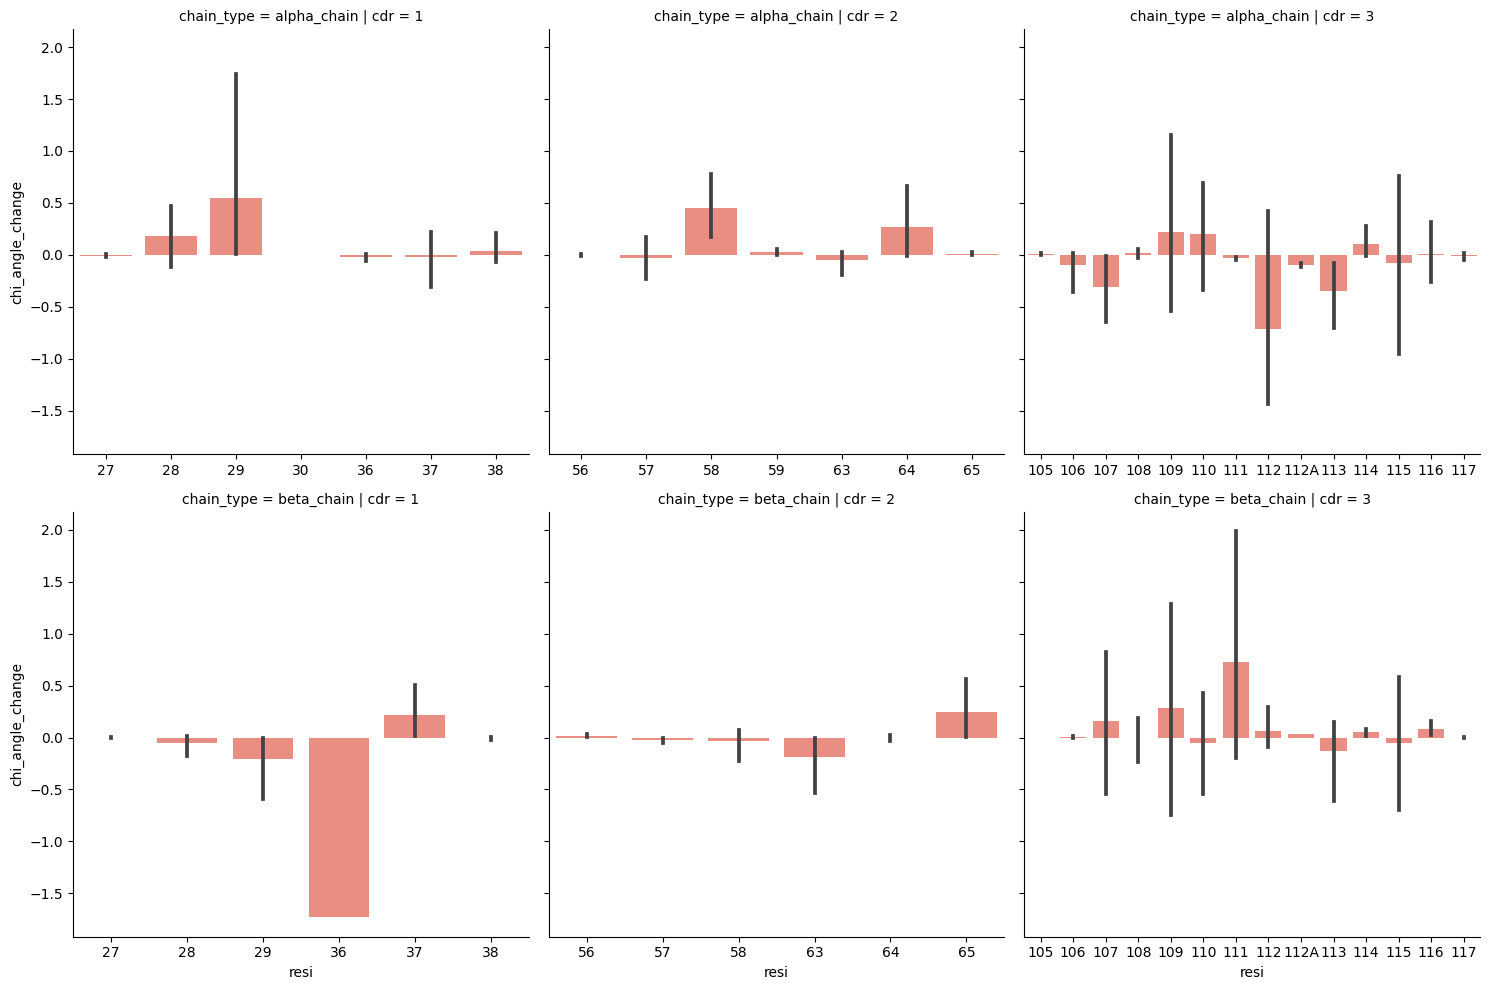

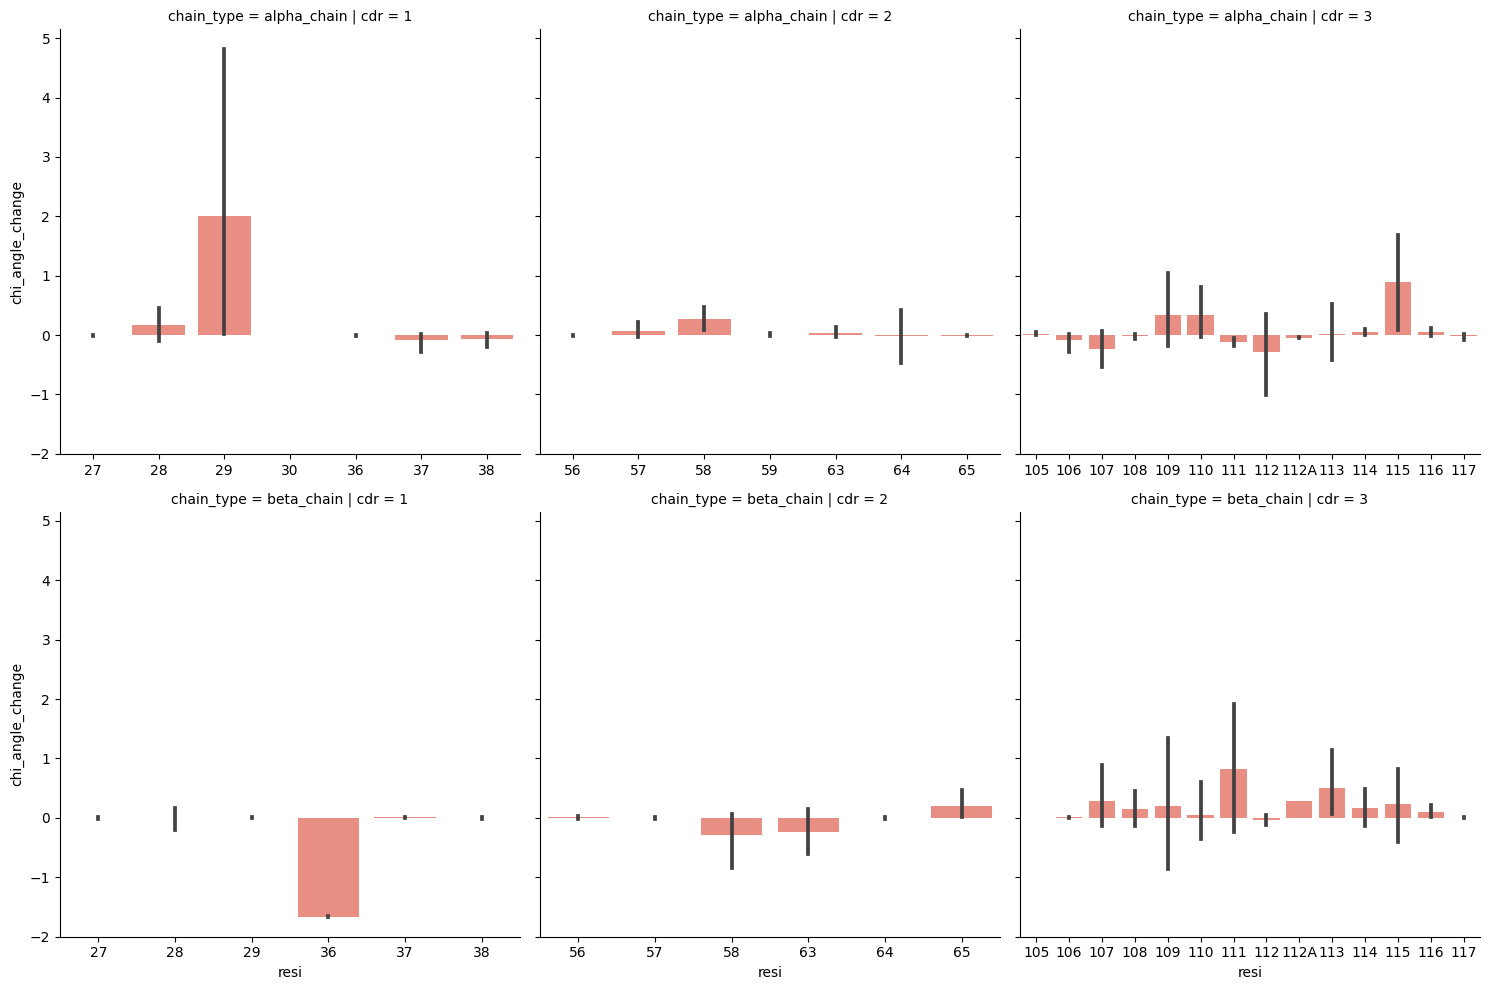

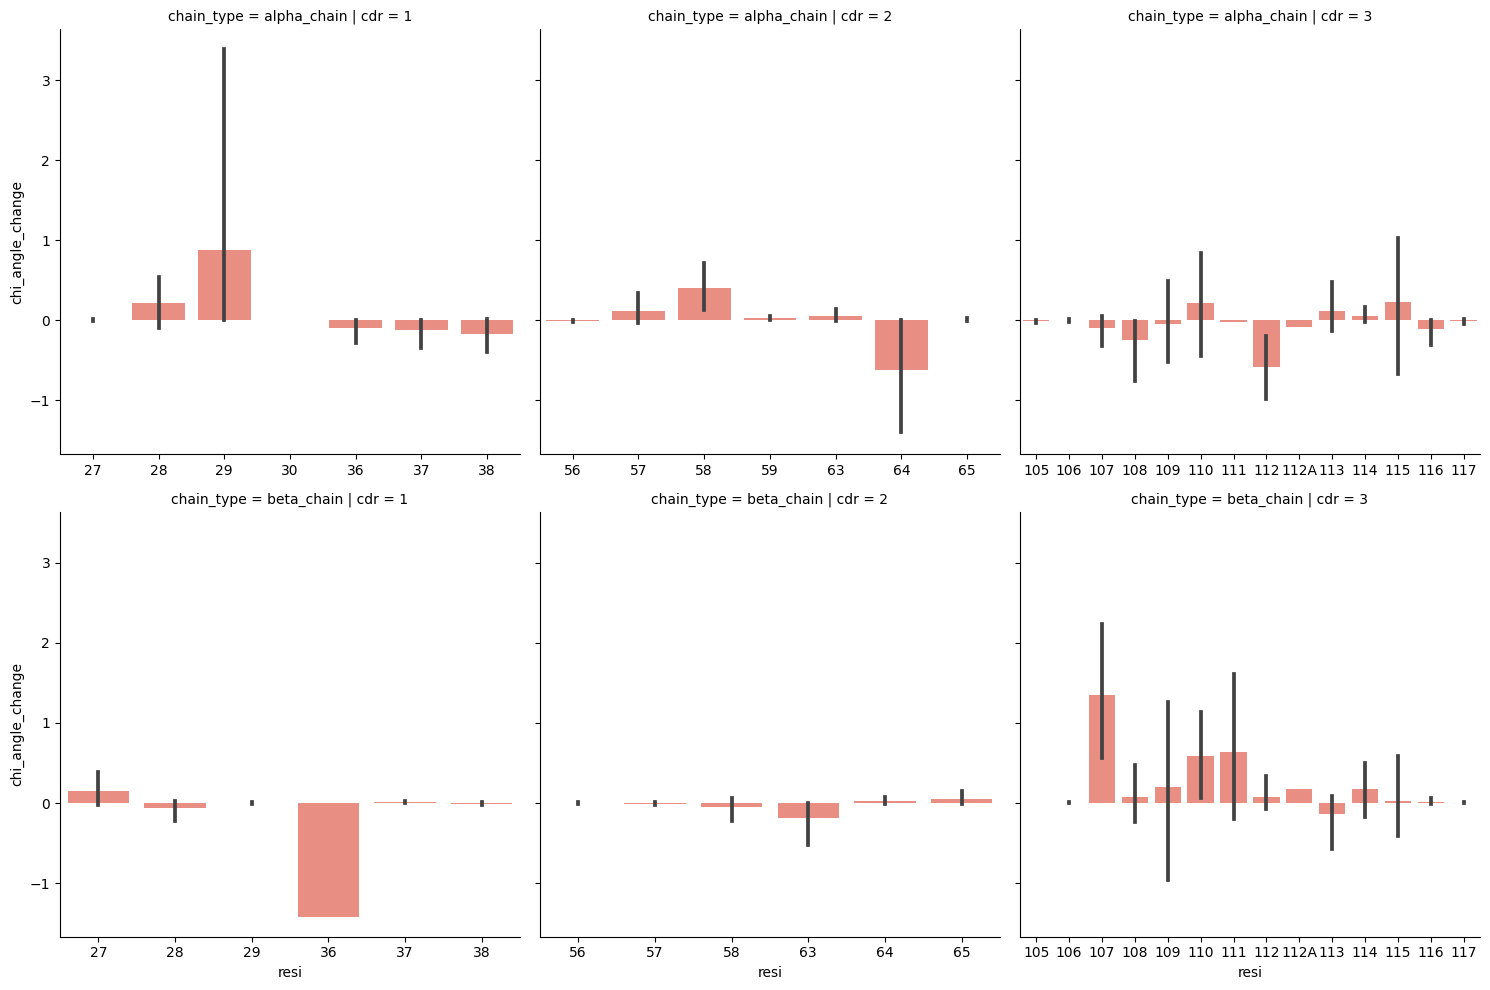

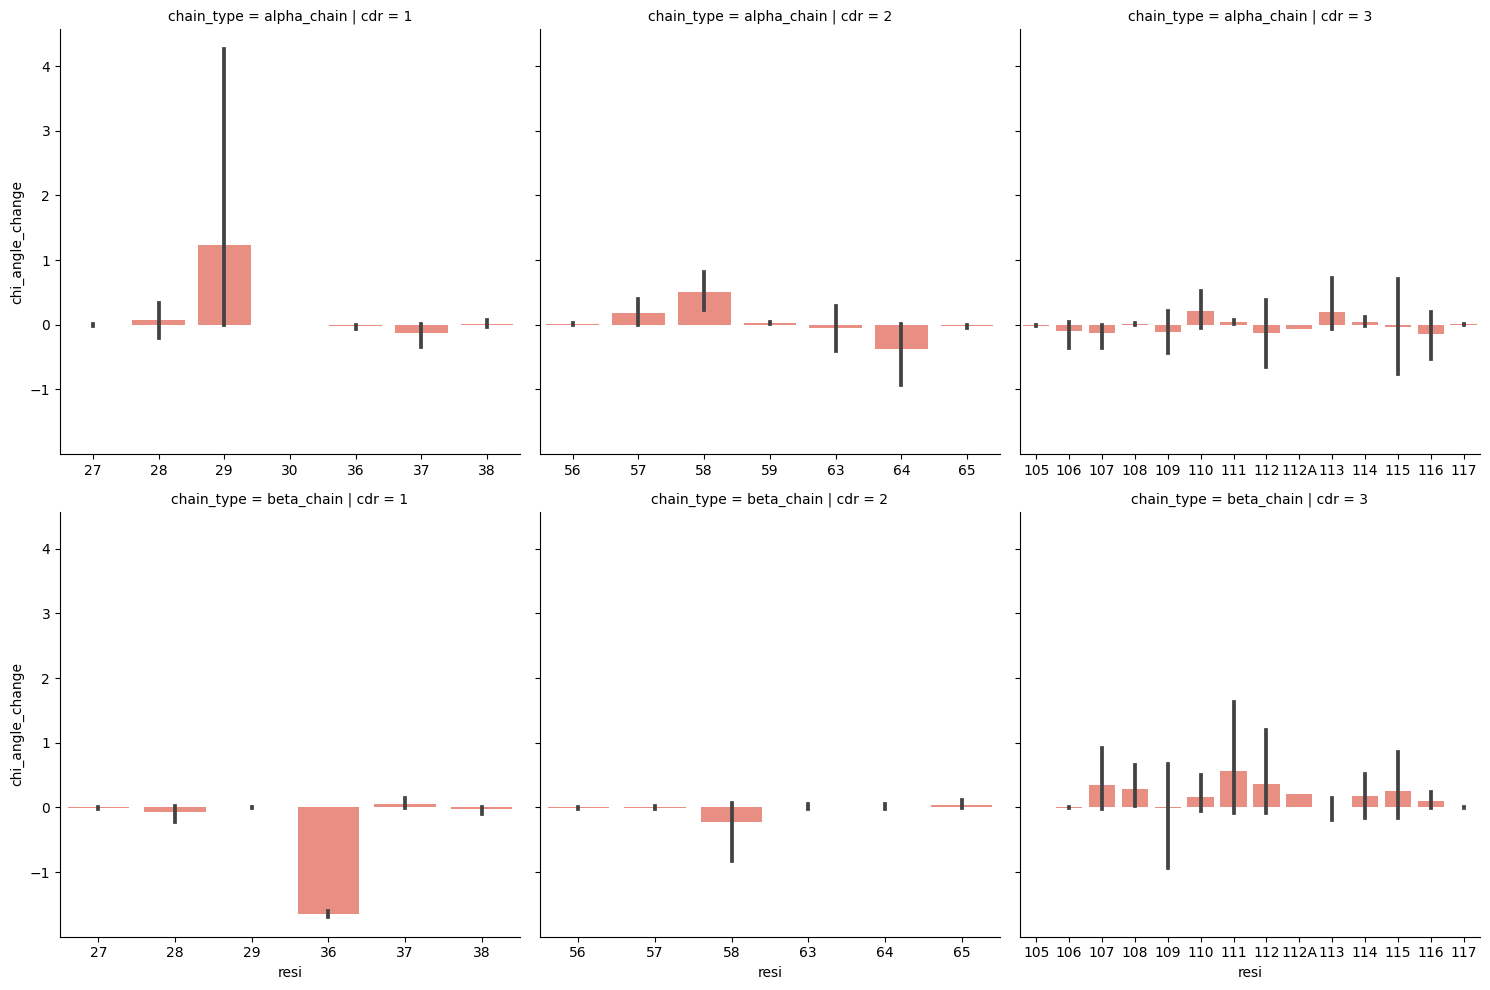

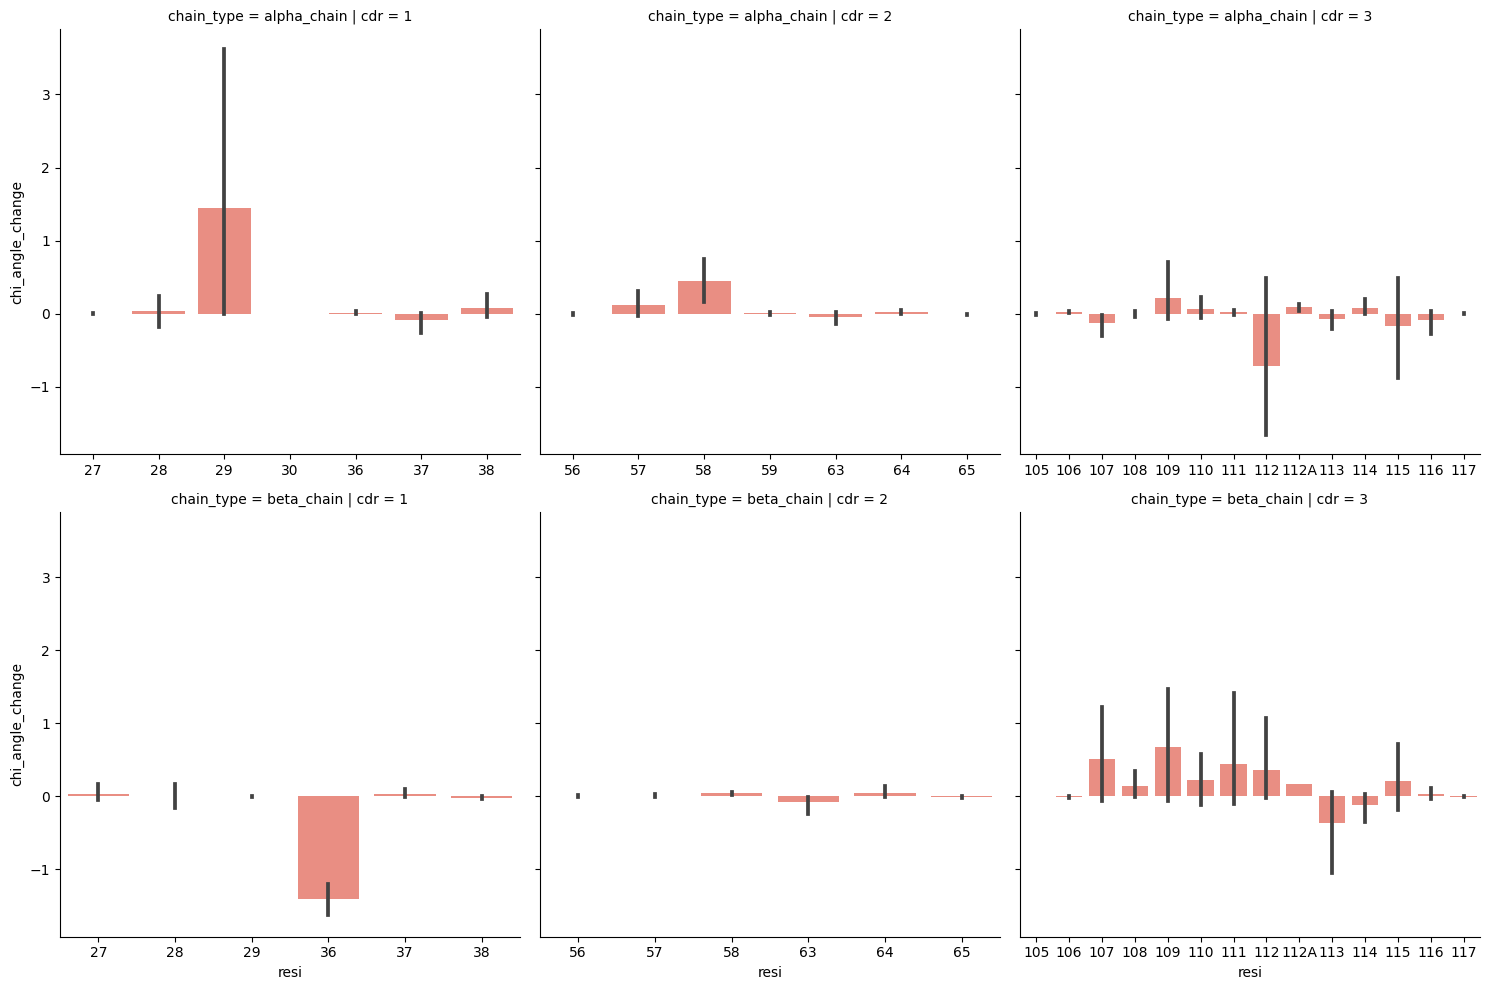

In [18]:
for model_rank in range(5):
    sns.catplot(apo_holo.query('model_rank == @model_rank').sort_values('resi'),
                x='resi', y='chi_angle_change',
                row='chain_type', col='cdr',
                color='salmon',
                sharex=False,
                kind='bar')

/package/python-cbrg/current/3.11/lib/python3.11/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/package/python-cbrg/current/3.11/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/package/python-cbrg/current/3.11/lib/python3.11/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/package/python-cbrg/current/3.11/lib/python3.11/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/package/python-cbrg/current/3.11/lib/python3.11/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/package/python-cbrg/current/3.11/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  retur

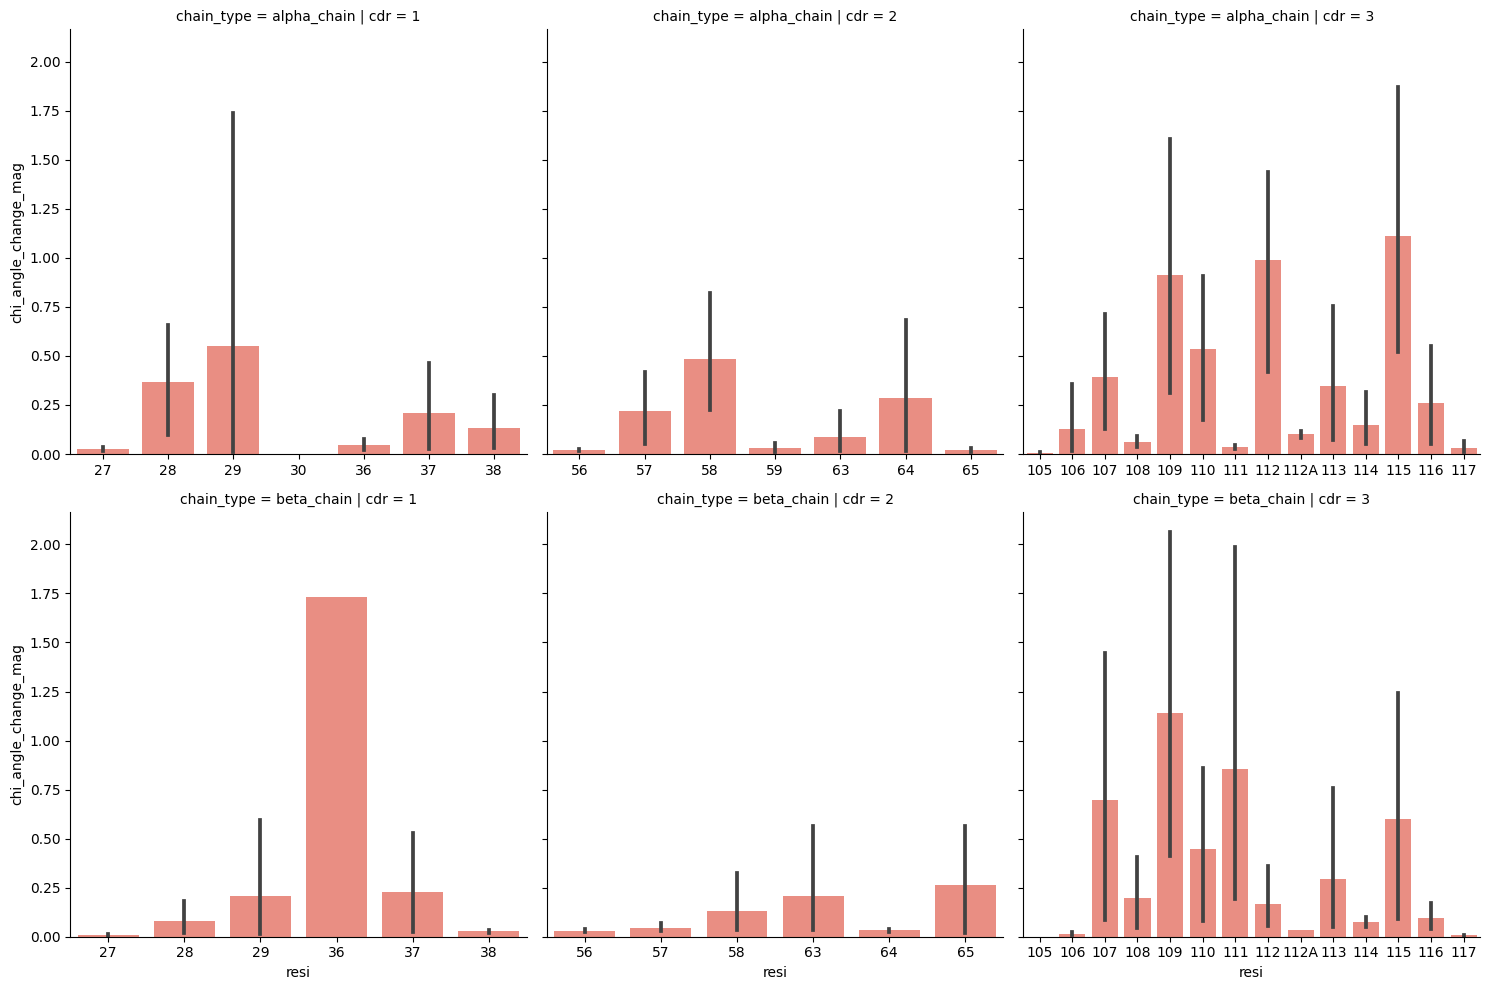

In [19]:
sns.catplot(apo_holo.query('model_rank == 0').sort_values('resi'),
            x='resi', y='chi_angle_change_mag',
            row='chain_type', col='cdr',
            color='salmon',
            sharex=False,
            kind='bar')

/package/python-cbrg/current/3.11/lib/python3.11/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/package/python-cbrg/current/3.11/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/package/python-cbrg/current/3.11/lib/python3.11/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/package/python-cbrg/current/3.11/lib/python3.11/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/package/python-cbrg/current/3.11/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


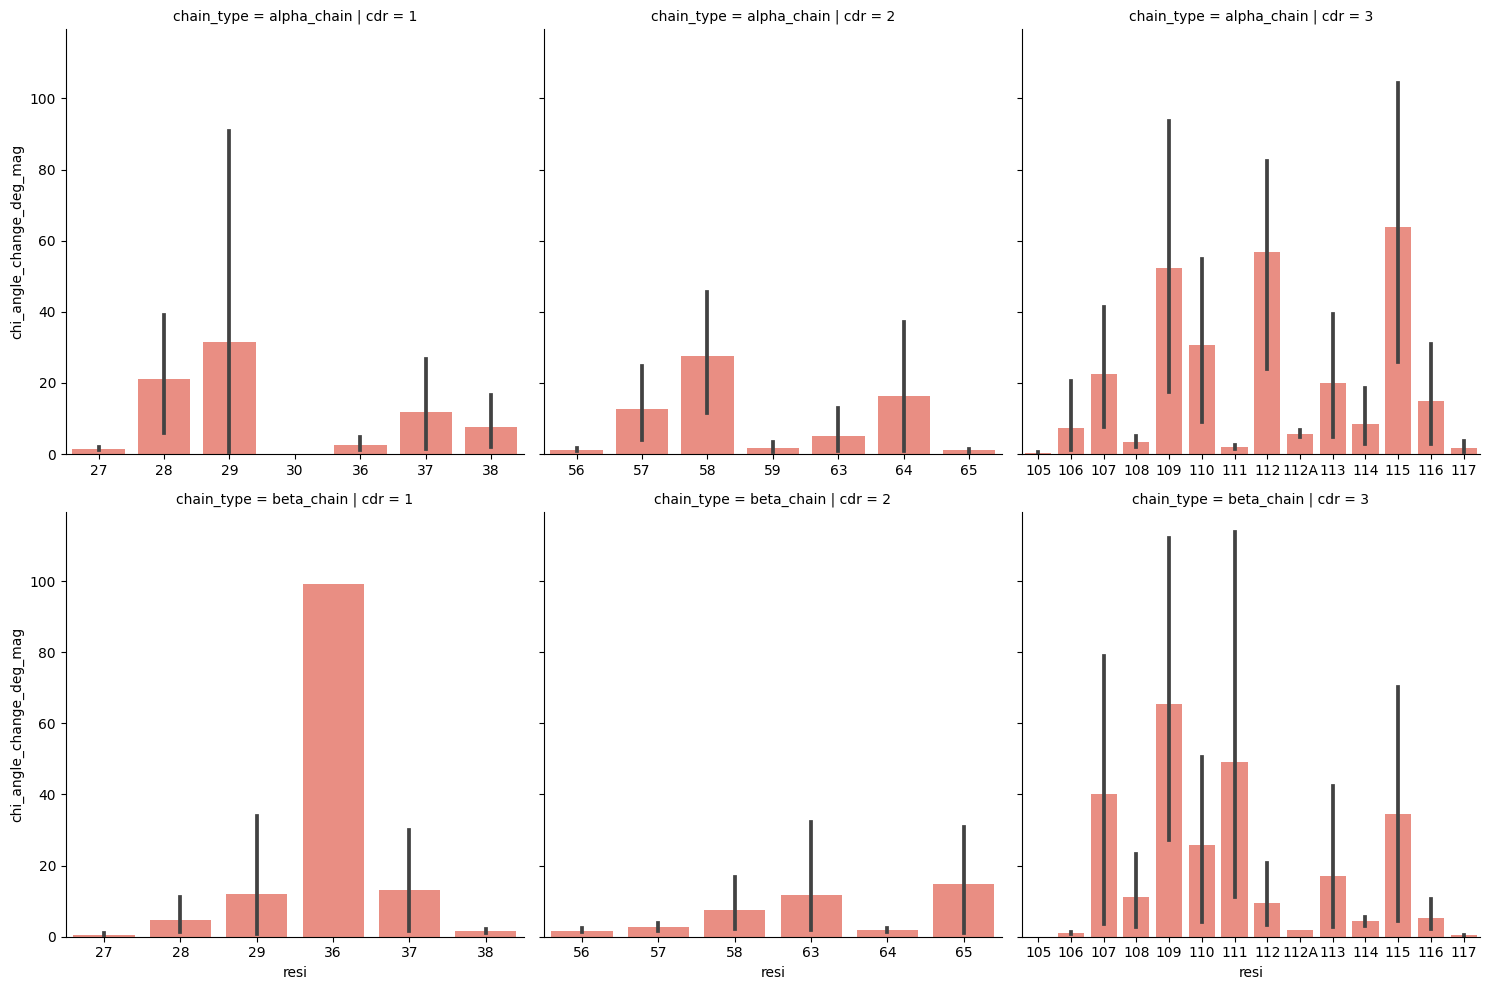

In [20]:
sns.catplot(apo_holo.query('model_rank == 0').sort_values('resi'),
            x='resi', y='chi_angle_change_deg_mag',
            row='chain_type', col='cdr',
            color='salmon',
            sharex=False,
            kind='bar')

## Correlation

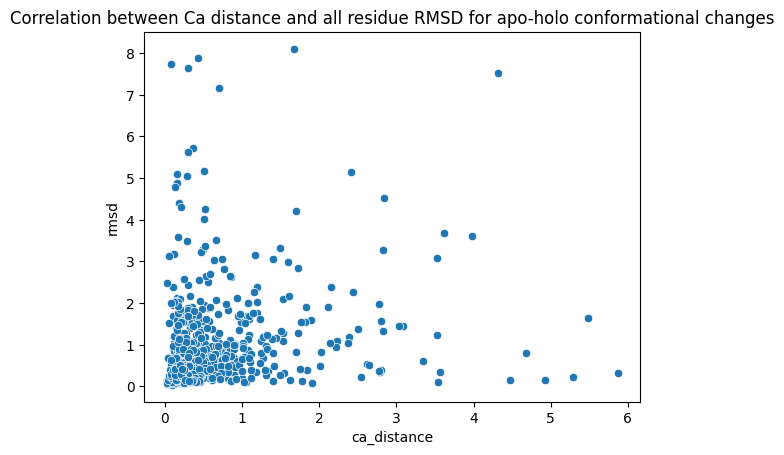

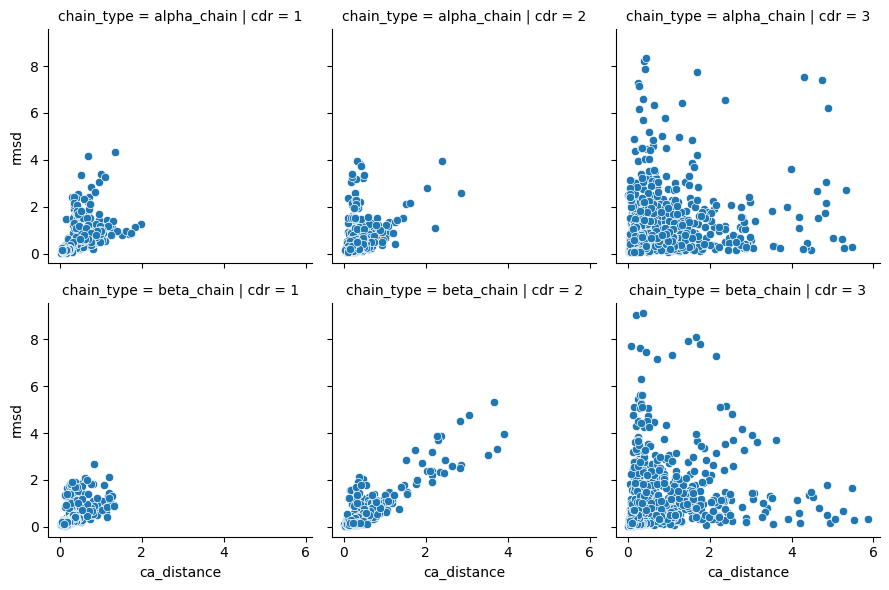

In [21]:
sns.scatterplot(apo_holo.query('model_rank == 0'), x='ca_distance', y='rmsd')
plt.title('Correlation between Ca distance and all residue RMSD for apo-holo conformational changes')

g = sns.FacetGrid(apo_holo, col='cdr', row='chain_type')
g.map(sns.scatterplot, 'ca_distance', 'rmsd')

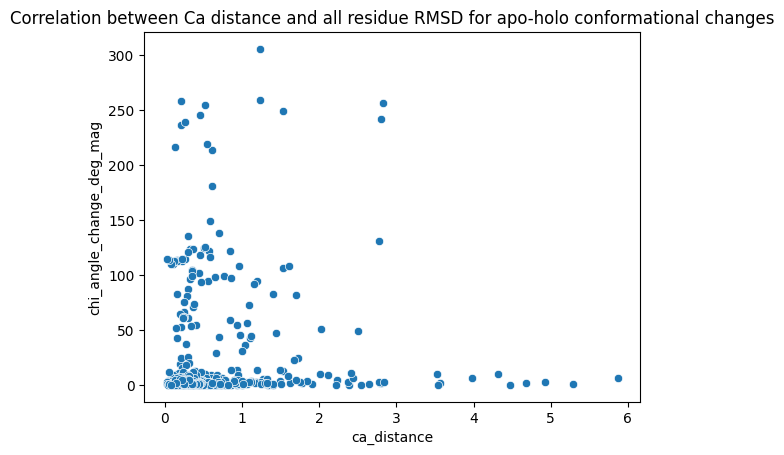

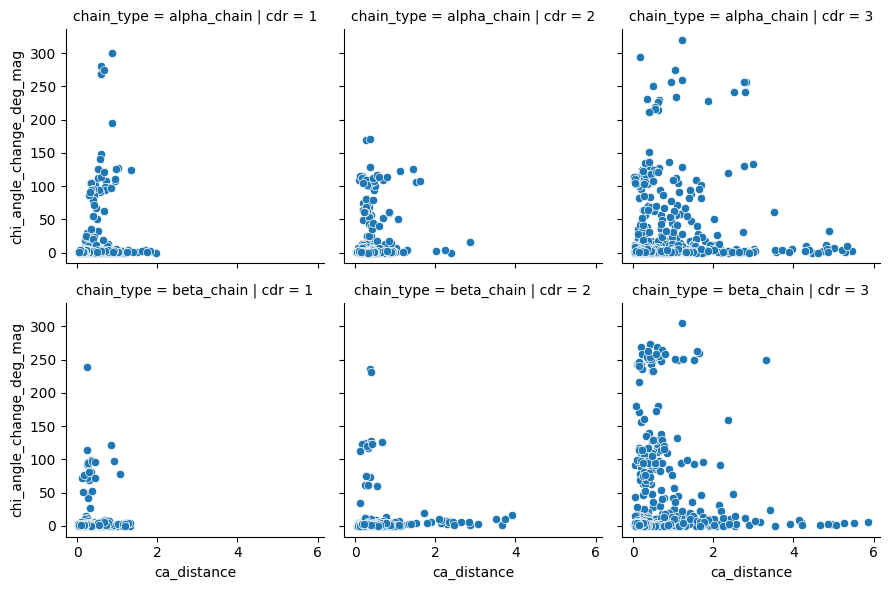

In [23]:
sns.scatterplot(apo_holo.query('model_rank == 0'), x='ca_distance', y='chi_angle_change_deg_mag')
plt.title('Correlation between Ca distance and all residue RMSD for apo-holo conformational changes')

g = sns.FacetGrid(apo_holo, col='cdr', row='chain_type')
g.map(sns.scatterplot, 'ca_distance', 'chi_angle_change_deg_mag')